<a href="https://colab.research.google.com/github/aenoboa1/Draft_ML_EmotionAPP/blob/main/testing_daisee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from google.colab import drive
import visualkeras
drive._mount('/content/drive')


#matplotlib styles
plt.style.use(['ggplot'])
sns.set(rc={'figure.figsize':(10,10)})

In [ ]:
!git clone https://github.com/federicovergallo/Engagement-recognition-using-DAISEE-dataset


Cloning into 'Engagement-recognition-using-DAISEE-dataset'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 73 (delta 29), reused 49 (delta 16), pack-reused 0
Unpacking objects: 100% (73/73), done.


In [ ]:
!mkdir /content/DAiSEE ; unzip  -qq /content/drive/MyDrive/DATA/datasets/DAiSEE.zip -d /content/DAiSEE


In [ ]:
!python /content/Engagement-recognition-using-DAISEE-dataset/daisee_data_preprocessing.py

In [ ]:
! zip -r tfrecords.zip /content/tfrecords
 

updating: content/tfrecords/ (stored 0%)
updating: content/tfrecords/test.tfrecords (deflated 73%)
updating: content/tfrecords/train.tfrecords (deflated 63%)
updating: content/tfrecords/val.tfrecords (deflated 78%)


In [ ]:
!python /content/Engagement-recognition-using-DAISEE-dataset/train.py

### Train Code

In [15]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as kl
import tensorflow.keras.losses
from tensorflow.keras.applications.resnet50 import ResNet50


In [33]:
!wget https://raw.githubusercontent.com/aenoboa1/Engagement-recognition-using-DAISEE-dataset/master/daisee_data_preprocessing.py

--2021-12-27 17:42:05--  https://raw.githubusercontent.com/aenoboa1/Engagement-recognition-using-DAISEE-dataset/master/daisee_data_preprocessing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8681 (8.5K) [text/plain]
Saving to: ‘daisee_data_preprocessing.py’

daisee_data_preproc 100%[===================>]   8.48K  --.-KB/s    in 0s      

2021-12-27 17:42:05 (71.4 MB/s) - ‘daisee_data_preprocessing.py’ saved [8681/8681]



In [34]:
from daisee_data_preprocessing import DataPreprocessing
import datetime
import os
from tqdm import tqdm

In [35]:
BATCH_SIZE = 32
LR = 0.005
EPOCHS = 100

In [36]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_dir = 'checkpoints/'
log_dir = 'logs/'


In [38]:
preprocessing_class = DataPreprocessing()


In [44]:
# Open train set
tfrecord_path = '/content/tfrecords/test.tfrecords'
train_set = tf.data.TFRecordDataset(tfrecord_path)
# Parse the record into tensors with map.
train_set = train_set.map(preprocessing_class.decode)
train_set = train_set.shuffle(1)
train_set = train_set.batch(BATCH_SIZE)

In [43]:
# Open test set
tfrecord_path = '/content/tfrecords/train.tfrecords'
test_set = tf.data.TFRecordDataset(tfrecord_path)
# Parse the record into tensors with map.
test_set = test_set.map(preprocessing_class.decode)
test_set = test_set.shuffle(1)
test_set = test_set.batch(BATCH_SIZE)

In [42]:
# Open val set
tfrecord_path = '/content/tfrecords/val.tfrecords'
val_set = tf.data.TFRecordDataset(tfrecord_path)
# Parse the record into tensors with map.
val_set = val_set.map(preprocessing_class.decode)
val_set = val_set.shuffle(1)
val_set = val_set.batch(BATCH_SIZE)

In [45]:
def create_log_dir(log_dir, checkpoint_dir):
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    if not os.path.exists(checkpoint_dir):
        os.mkdir(checkpoint_dir)

In [46]:
def network():
    model = tf.keras.Sequential()
    model.add(kl.InputLayer(input_shape=(224, 224, 3)))
    # First conv block
    model.add(kl.Conv2D(filters = 96, kernel_size=7, padding='same', strides=2))
    model.add(tf.keras.layers.ReLU())
    model.add(kl.MaxPooling2D(pool_size=(3, 3)))
    # Second conv block
    model.add(kl.Conv2D(filters = 256, kernel_size=5, padding='same', strides=1))
    model.add(tf.keras.layers.ReLU())
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    # Third-Fourth-Fifth conv block
    for i in range(3):
        model.add(kl.Conv2D(filters = 512, kernel_size=3, padding='same', strides=1))
        model.add(tf.keras.layers.ReLU())
    model.add(kl.MaxPooling2D(pool_size=(3, 3)))
    # Flatten
    model.add(kl.Flatten())
    # First FC 
    model.add(kl.Dense(4048))
    # Second Fc
    model.add(kl.Dense(4048))
    # Third FC
    model.add(kl.Dense(4))
    # Softmax at the end
    model.add(kl.Softmax())
    
    return model

In [47]:
model = network()

In [49]:
!pip install visualkeras ; ! pip install ThreadedFileLoader # module for CNN visualization


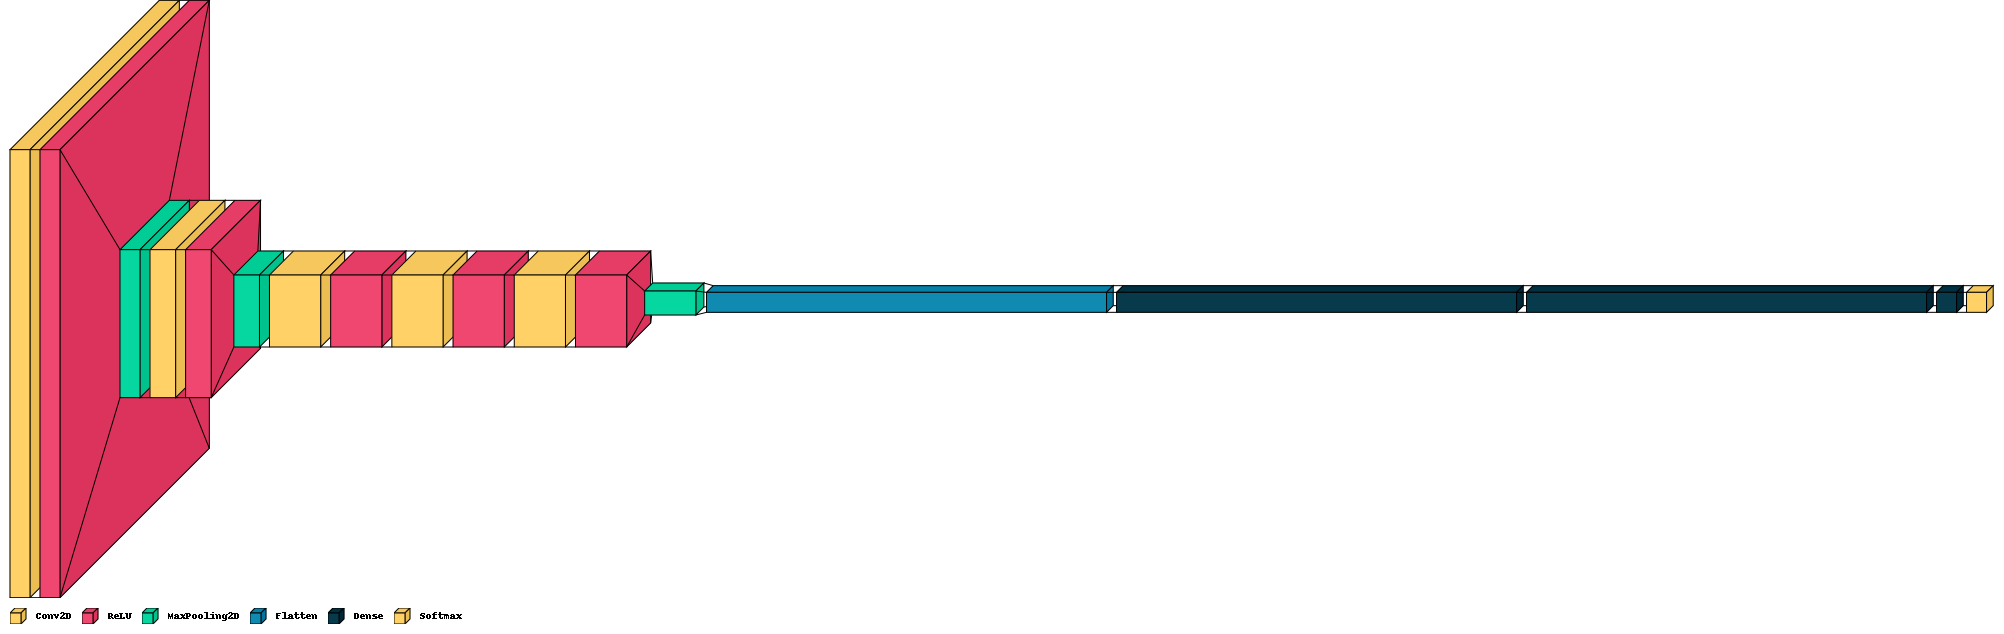

In [53]:
visualkeras.layered_view(model).show()
visualkeras.layered_view(model,legend=True)

In [54]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss_value = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    # Track progress
    train_loss_avg.update_state(loss_value)
    train_accuracy.update_state(y, logits)
    return loss_value

In [55]:
@tf.function
def test_step(x, y, set_name):
    logits = model(x)
    if set_name == 'val':
        val_accuracy.update_state(y, logits)
    else:
        test_accuracy.update_state(y, logits)

In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
create_log_dir(log_dir, checkpoint_dir)
train_summary_writer = tf.summary.create_file_writer(log_dir)

In [58]:
train_loss_avg = tf.keras.metrics.Mean()
train_accuracy = tf.keras.metrics.MeanAbsoluteError()
val_accuracy = tf.keras.metrics.MeanAbsoluteError()
test_accuracy = tf.keras.metrics.MeanAbsoluteError()

In [ ]:
for epoch in range(EPOCHS):
    # Training loop
    for x_batch_train, y_batch_train in tqdm(train_set, total=1517):
        # Do step
        loss_value = train_step(x_batch_train, y_batch_train)
        
    # Test on validation set
    for x_batch_val, y_batch_val in val_set:
        test_step(x_batch_val, y_batch_val, 'val')
    
    # Reset training metrics at the end of each epoch
    train_acc = train_accuracy.result()
    train_accuracy.reset_states()
    val_acc = val_accuracy.result()
    val_accuracy.reset_states()
    
    with train_summary_writer.as_default():
        tf.summary.scalar('Train loss', train_loss_avg.result(), step=epoch)
        tf.summary.scalar('Train MAE', train_acc, step=epoch)
        tf.summary.scalar('Val MAE', val_acc, step=epoch)
        
    if epoch % 10 == 0:
        tf.keras.models.save_model(model, '{}/Epoch_{}_model.hp5'.format(checkpoint_dir, str(epoch)), save_format="h5")

 55%|█████▍    | 833/1517 [00:50<00:41, 16.63it/s]


  2%|▏         | 29/1517 [00:01<01:11, 20.85it/s]

In [ ]:
# Test on validation set
for x_batch_test, y_batch_test in test_set:
    test_step(x_batch_test, y_batch_test, 'test')
test_set_acc = test_accuracy.result()

### Saving Models

In [ ]:
!zip -r scratch_models.zip /content/checkpoints/scratch_aug

  adding: content/checkpoints/scratch_aug/ (stored 0%)
  adding: content/checkpoints/scratch_aug/Epoch_250_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_0_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_350_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_450_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_100_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_200_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_50_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_400_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_150_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_300_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_500_model.hp5 (deflated 7%)


In [ ]:
import tensorflow as tf 
raw_dataset = tf.data.TFRecordDataset("/content/tfrecords/train.tfrecords")

for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

In [ ]:
example


## Testing predictions

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
GCS_PATH = "/"
BATCH_SIZE = 64
IMAGE_SIZE = [1024, 1024]

In [ ]:
model.compile()

In [ ]:
from keras.models import load_model

model =load_model('/content/checkpoints/scratch_aug/Epoch_400_model.hp5')


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     3584      
                                                                 
 re_lu_3 (ReLU)              (None, 112, 112, 128)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 256)       295168    
                                                                 
 re_lu_4 (ReLU)              (None, 28, 28, 256)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                  

In [ ]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('/content/DAiSEE/DAiSEE/DataSet/Data/Train/310082/3100821015/310082101534.jpg')

In [ ]:
image

array([[[[0.7294118 , 0.6862745 , 0.7176471 ],
         [0.7294118 , 0.6862745 , 0.7176471 ],
         [0.7294118 , 0.6862745 , 0.7176471 ],
         ...,
         [0.7890167 , 0.72235006, 0.7537226 ],
         [0.7882354 , 0.72156876, 0.7529413 ],
         [0.7882353 , 0.72156864, 0.7529412 ]],

        [[0.7294118 , 0.6862745 , 0.7176471 ],
         [0.7294118 , 0.6862745 , 0.7176471 ],
         [0.7294118 , 0.6862745 , 0.7176471 ],
         ...,
         [0.7890167 , 0.72235006, 0.7537226 ],
         [0.7882354 , 0.72156876, 0.7529413 ],
         [0.7882353 , 0.72156864, 0.7529412 ]],

        [[0.7294118 , 0.6862745 , 0.7176471 ],
         [0.7294118 , 0.6862745 , 0.7176471 ],
         [0.7294118 , 0.6862745 , 0.7176471 ],
         ...,
         [0.7890167 , 0.72235006, 0.7537226 ],
         [0.7882354 , 0.72156876, 0.7529413 ],
         [0.7882353 , 0.72156864, 0.7529412 ]],

        ...,

        [[0.19215687, 0.26666668, 0.39607844],
         [0.19215798, 0.2666678 , 0.39607957]

In [ ]:
model.predict(image)

array([[0.22633769, 0.99989736, 0.5748068 , 0.2610716 ]], dtype=float32)